Training a neural network on MNIST data imported using **Pytorch**, find examples that "fool" that trained network and propose a way to deal with these examples.

In [267]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt


In [268]:
transform = transforms.Compose([transforms.ToTensor()
                              ])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, test_set = torch.utils.data.random_split(mnist_trainset, [50000, 10000])
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [269]:

trainData = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
valData = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
testData = torch.utils.data.DataLoader(mnist_testset, batch_size=100,shuffle=True)

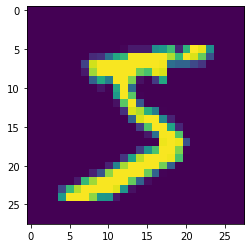

In [270]:
plt.imshow(mnist_trainset[0][0][0])

In [271]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=15,            
                kernel_size=5,              
                stride=1,               
            ),    
            nn.MaxPool2d(kernel_size=2), 
            nn.ReLU(),                           
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(15, 30, 5), 
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),                                   
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(480,64)
        self.fc2 = nn.Linear(64,10) 
        self.dropout = nn.Dropout2d(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)     
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)
        return output
cnn = CNN()


In [272]:
loss_func = nn.CrossEntropyLoss()   

from torch import optim
from torch.autograd import Variable

def train(num_epochs, cnn, loaders, Temp = 0):
    loss_val = []
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
    total_step = len(trainData)
        
    for epoch in range(num_epochs):
        loss_per_epoch = 0
        for i, (images, labels) in enumerate(trainData):
            
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)  
            if(Temp > 0):
                output = F.log_softmax(output/Temp,dim=1)       # to incorporate the defense in the code for question 5
            loss = loss_func(output, b_y)
              
            optimizer.zero_grad()           
            
            loss.backward()              
            optimizer.step()                
            loss_per_epoch+=loss.item()
            
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs,  loss_per_epoch/total_step))
        loss_val.append(loss_per_epoch/total_step)

    return loss_val
epochs = 10
loss_val = train(epochs, cnn, trainData)

Epoch [1/10],  Loss: 1.3709
Epoch [2/10],  Loss: 1.2777
Epoch [3/10],  Loss: 1.2688
Epoch [4/10],  Loss: 1.2616
Epoch [5/10],  Loss: 1.2593
Epoch [6/10],  Loss: 1.2494
Epoch [7/10],  Loss: 1.2508
Epoch [8/10],  Loss: 1.2354
Epoch [9/10],  Loss: 1.2516
Epoch [10/10],  Loss: 1.2336


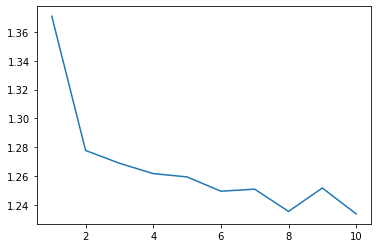

In [273]:

plt.plot(np.arange(1,epochs+1),loss_val)

In [274]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testData:
            test_output= cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Accuracy of the model on the 10000 test images: 0.98


In [275]:
torch.save(cnn.state_dict(), "trained_model.pth")
epsilons = [0, .05, .15, .25]
pretrained_model = "trained_model.pth"
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = CNN().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)

In [276]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [277]:
def test( model, device, testData, epsilon, Temp = 0):

    correct = 0
    adv_examples = []

    for data, target in testData:

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        if (Temp >0):
            output = F.log_softmax(output/Temp,dim=1)     # to incorporate the defense in the code for question 5
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()

        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(testData))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testData), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [278]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, valData, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9666 / 10000 = 0.9666
Epsilon: 0.05	Test Accuracy = 5132 / 10000 = 0.5132
Epsilon: 0.15	Test Accuracy = 1553 / 10000 = 0.1553
Epsilon: 0.25	Test Accuracy = 1254 / 10000 = 0.1254


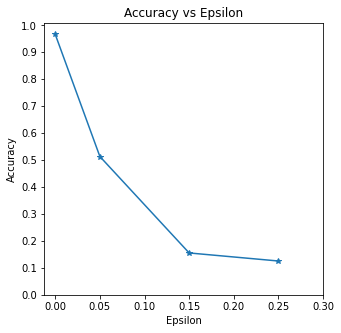

In [279]:
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

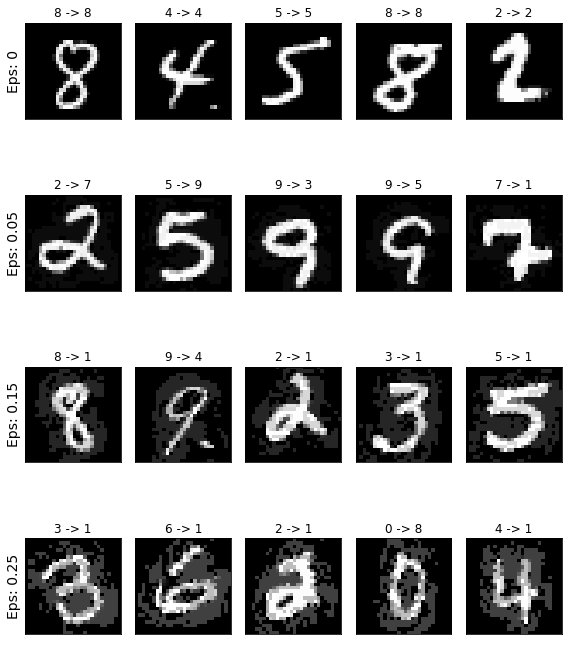

In [280]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

#### Defensive Distillation to reduce the effectiveness of adversarial samples on neural networks

In [288]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=8,            
                kernel_size=5,              
                stride=1,               
            ),    
            nn.MaxPool2d(kernel_size=2), 
            nn.ReLU(),                           
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(8, 15, 5), 
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),                                   
        )
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(240,32)
        self.fc2 = nn.Linear(32,10) 
        self.dropout = nn.Dropout2d(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)     
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [289]:

def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

    modelF = CNN().to(device)
    
    modelF1 = CNN1().to(device)
    print("Epoch - Loss for Model 1 - modelF")
    lossF=train(epochs, modelF, train_loader, Temp)
    
  #converting target labels to soft labels
    for data in train_loader:
        input, label  = data[0].to(device),data[1].to(device)
        softlabel  = F.log_softmax(modelF(input),dim=1)
        data[1] = softlabel

    print("Epoch - Loss for Model 2 - modelF1")
    lossF1=train(epochs, modelF1, train_loader, Temp)

    model = CNN1().to(device)
    model.load_state_dict(modelF1.state_dict())
    
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,val_loader,eps,1)
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title("FGSM")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()


Epoch - Loss for Model 1 - modelF
Epoch [1/10],  Loss: 1.3576
Epoch [2/10],  Loss: 1.2216
Epoch [3/10],  Loss: 1.2128
Epoch [4/10],  Loss: 1.2021
Epoch [5/10],  Loss: 1.1955
Epoch [6/10],  Loss: 1.2057
Epoch [7/10],  Loss: 1.1825
Epoch [8/10],  Loss: 1.1889
Epoch [9/10],  Loss: 1.1862
Epoch [10/10],  Loss: 1.1880
Epoch - Loss for Model 2 - modelF1
Epoch [1/10],  Loss: 1.4089
Epoch [2/10],  Loss: 1.2723
Epoch [3/10],  Loss: 1.2386
Epoch [4/10],  Loss: 1.2240
Epoch [5/10],  Loss: 1.2235
Epoch [6/10],  Loss: 1.2196
Epoch [7/10],  Loss: 1.2235
Epoch [8/10],  Loss: 1.2128
Epoch [9/10],  Loss: 1.2106
Epoch [10/10],  Loss: 1.2162
Epsilon: 0	Test Accuracy = 3096 / 10000 = 0.3096
Epsilon: 0.05	Test Accuracy = 3142 / 10000 = 0.3142
Epsilon: 0.15	Test Accuracy = 3028 / 10000 = 0.3028
Epsilon: 0.25	Test Accuracy = 3111 / 10000 = 0.3111


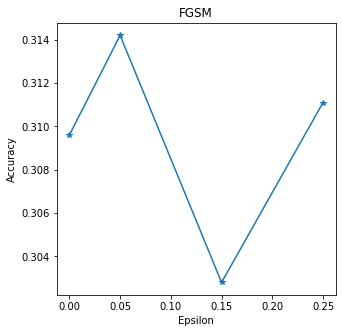

In [290]:
Temp=100
epochs=10
defense(device,trainData,valData,testData,epochs,Temp,epsilons)

Results from step 4 tell that FGSM attack reduces the test accuracy from 96.66% to 12.54% with epsilon from 0 to 0.25 where as during the defensive distillation used same network as modelF and modelF1, the accuracy is between 31% - 30%.

The drawback of using the defensive distilation is that it is bound by the general rules of the first model. The method is still prone to other attacks where the initial training dataset is corrupted.